In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.onnx
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
from sklearn import preprocessing
diabetes['Outcome'].replace(to_replace=[0],value=-1,inplace=True)
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,-1
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,-1
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
diabetes_features_orig=diabetes.loc[:,diabetes.columns!='Outcome']
diabetes_features_orig.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [4]:
diabetes_target=diabetes.loc[:,diabetes.columns=='Outcome'].values

In [5]:
minmax_scale=preprocessing.MinMaxScaler().fit(diabetes_features_orig)
diabetes_features = minmax_scale.transform(diabetes_features_orig)
print(diabetes_features)

[[0.35294118 0.74371859 0.59016393 ... 0.50074516 0.23441503 0.48333333]
 [0.05882353 0.42713568 0.54098361 ... 0.39642325 0.11656704 0.16666667]
 [0.47058824 0.91959799 0.52459016 ... 0.34724292 0.25362938 0.18333333]
 ...
 [0.29411765 0.6080402  0.59016393 ... 0.390462   0.07130658 0.15      ]
 [0.05882353 0.63316583 0.49180328 ... 0.4485842  0.11571307 0.43333333]
 [0.05882353 0.46733668 0.57377049 ... 0.45305514 0.10119556 0.03333333]]


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [6]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(diabetes_features, diabetes_target)

xtraintensor = torch.from_numpy(xtrain).float()
ytraintensor = torch.from_numpy(ytrain).float()
print("Size of X feature set")
xtraintensor.size()

Size of X feature set


torch.Size([576, 8])

In [7]:
import torch.nn.functional as F
class DiabetesPredictionModel(torch.nn.Module):
    def __init__(self):
        super(DiabetesPredictionModel, self).__init__()
        self.linear_projection1=torch.nn.Linear(8,2)
        self.linear_projection2=torch.nn.Linear(2,1)
    def forward(self,x):
        output=F.tanh(self.linear_projection1(x))
        output=F.tanh(self.linear_projection2(output))
        return output
    

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


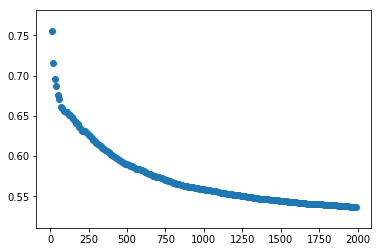

In [8]:
model = DiabetesPredictionModel()
minibatch_size = 32
learning_rate=1e-2

with torch.no_grad():
    for param in model.parameters():
        param.uniform_(0,0.01)
        
from sklearn.metrics import accuracy_score
import torch.optim as optim

optimizer = optim.Adam(model.parameters(),0.01)

#loop de treino
losses = {}
total_loss=0
for i in range(0,2000):
    minibatch_index=torch.randperm(xtraintensor.size(0))
    minibatch_index = minibatch_index[:minibatch_size]
    minibatchx = xtraintensor[minibatch_index]
    minibatchy = ytraintensor[minibatch_index]
    
    #forward pass
    output=model(minibatchx)
    loss=F.soft_margin_loss(output,minibatchy)
    
    #backward pass
    loss.backward()
    total_loss +=loss.item()
    
    #optimizer pass
    optimizer.step()
    optimizer.zero_grad()
    
    if i>0 and i%10==0:
        losses[i]=total_loss/i
        
plt.scatter(losses.keys(), losses.values())    

In [13]:
vdata = [0.058,0.643,0.803,0.414,0.068,0.476,0.530,0.2]
v = torch.tensor(vdata)
outputs = model(v)
print(outputs)

tensor([0.1946], grad_fn=<TanhBackward>)


In [11]:
torch.save(model.state_dict(),"./diabetes_model.dat")
output_filename = "./model.onnx"
entrada = xtraintensor[0]
torch_out = torch.onnx._export(model,         # model being run
                               entrada,                   # model input 
                               output_filename,     # where to save the model 
                               export_params=True)  # store the trained weight

In [ ]:
#Comandos para compilar o modelo

#Abrir prompt de comando pelo Anaconda

#D:\2019\ELL\tools\importers\onnx\python onnx_import.py C:\Users\walte\Documents\anaconda\model.onnx

#D:\2019\ELL\build\bin\Release\compile -imap C:\Users\walte\Documents\anaconda\model.ell -cfn Predict -cmn model --bitcode -od C:\Users\walte\Documents\anaconda\ --fuseLinearOps True --header --blas false --optimize true --target custom --numBits 32 --cpu cortex-m4 --triple armv6m-gnueabi --features +vfp4,+d16,+soft-float

#D:\2019\ELL\external\LLVMNativeWindowsLibs.x64.6.0.1\llvm-6.0\bin>llc.exe C:\Users\walte\Documents\anaconda\model.bc -o C:\Users\walte\Documents\anaconda\model.S -O3 -filetype=asm -mtriple=armv6m-gnueabi -mcpu=cortex-m4 -relocation-model=pic -float-abi=soft -mattr=+vfp4,+d16